In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torch
from src.dataset import CellDataset
from easydict import EasyDict
from dotenv import load_dotenv
from src.augmentations import eval_transform
from pytorch_toolbelt.utils import set_manual_seed
from src.postprocessing import remove_overlapping_pixels, postprocess_predictions

from src.iou_metric import iou_map

current_dir = Path(".")

load_dotenv()
set_manual_seed(0)

Using manual seed: 0


In [2]:
plt.rcParams["figure.figsize"] = (8, 8)

weights_path = current_dir / "weights" / "maxim_baseline.ckpt"
assert weights_path.is_file(), f"File not found: {weights_path.absolute()}"

config = EasyDict(
    dataset_path=Path(os.environ['dataset_path']),
    val_size=0.2,
    device='cpu'
)

device = config.device

In [3]:
dataset = CellDataset(cfg=config, transform=eval_transform, mode='train')
image, target = dataset[0]
true_masks = target['masks']

print(image.size())
print(true_masks.size())

true_masks = true_masks.cpu().int().numpy()

torch.Size([1, 520, 704])
torch.Size([21, 520, 704])


In [4]:
model = maskrcnn_resnet50_fpn(progress=False, num_classes=2)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device)
model.eval()
print()

In [10]:
image = image.to(device)

with torch.no_grad():
    outputs = model.forward([image])

prediction = postprocess_predictions(outputs=outputs, mask_threshold=0.5, score_threshold=0.4)[0]


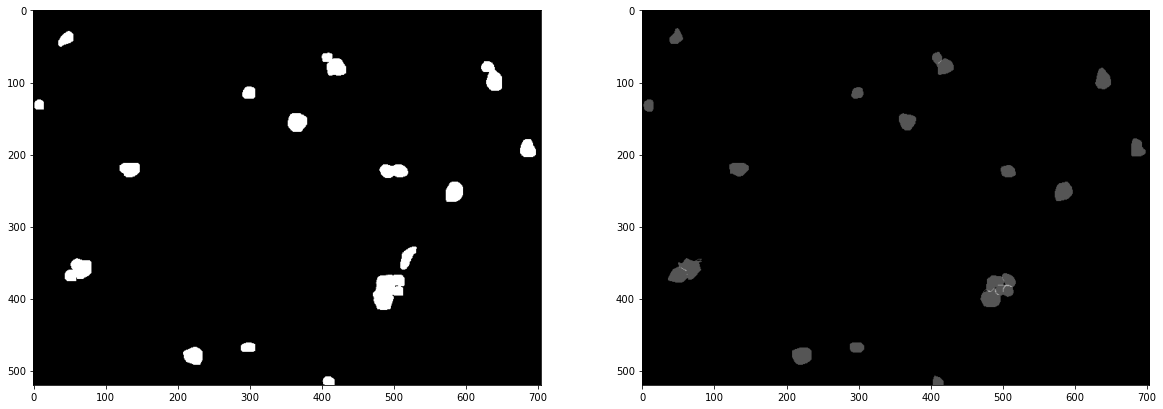

In [11]:
## Visualisation of predictions
pred_masks = prediction['masks']
true_masks = true_masks

pred_masks_2d = np.sum(pred_masks, axis=0)
true_masks_2d = np.sum(true_masks, axis=0)

fig, axis = plt.subplots(ncols=2, figsize=(20, 20))
axis[0].imshow(pred_masks_2d, cmap='gray')
axis[1].imshow(true_masks_2d,  cmap='gray')
plt.show()


In [12]:
## Calculation of iou score
score = iou_map(true_masks, prediction['masks'])
score

0.3214554201402133

In [13]:
from src.iou_metric import fast_iou
fast_iou(prediction['masks'], true_masks)

0.3276211158052671